# GeoCert : 2-dimensional Toy Example
In this example, we'll train a simple neural network and demonstrate the various capabilities of GeoCert.

The network training code was largely copied from [Eric Wong's repository found here.](https://github.com/locuslab/convex_adversarial/blob/master/examples/2D.ipynb)

In [1]:
! pip install --quiet torchvision

In [2]:
import sys

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial import HalfspaceIntersection
from torch.autograd import Variable
from torchvision import datasets, transforms

from geocert.geocert import GeoCert
from geocert.plnn import PLNN

In [3]:
%matplotlib inline
seaborn.set(font_scale=2)
seaborn.set_style("white")

[2, 20, 50, 20, 2]
0.6878679394721985 tensor(0.4167)
0.458894819021225 tensor(0.2500)
0.41214719414711 tensor(0.2500)
0.28566619753837585 tensor(0.1667)
0.1347718983888626 tensor(0.0833)
0.03275255858898163 tensor(0.)
0.01041971892118454 tensor(0.)
0.005326188635081053 tensor(0.)
0.003254170762374997 tensor(0.)
0.002198869362473488 tensor(0.)
0.0015940474113449454


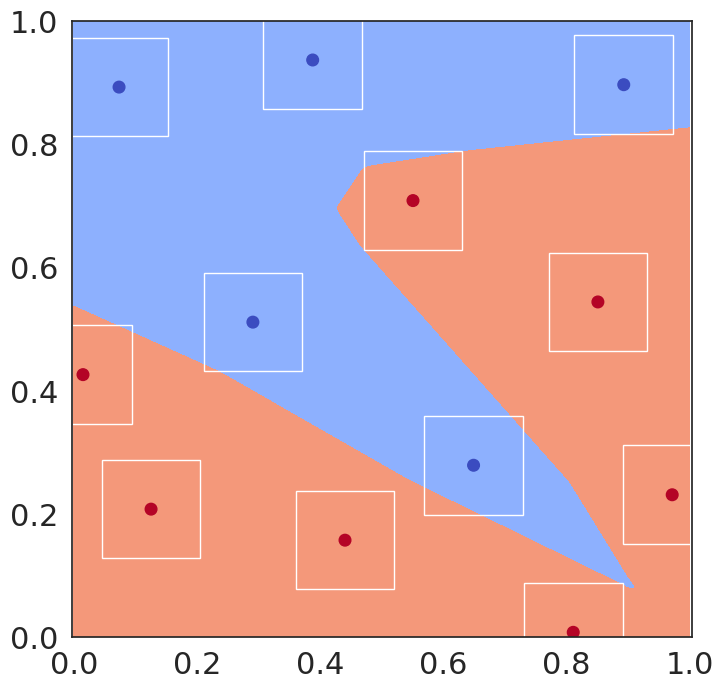

In [4]:
# Training block -- train a simple 2d Network
# --- define network
plnn_obj = PLNN(layer_sizes=[2, 20, 50, 20, 2])
net = plnn_obj.net

# --- define random training points
m = 12
np.random.seed(3)
x = [np.random.uniform(size=(2))]
r = 0.16
while (len(x) < m):
    p = np.random.uniform(size=(2))
    if min(np.abs(p - a).sum() for a in x) > 2 * r:
        x.append(p)
epsilon = r / 2
X = torch.Tensor(np.array(x))
torch.manual_seed(1)
y = (torch.rand(m) + 0.5).long()

# --- train network
opt = optim.Adam(net.parameters(), lr=1e-3)
for i in range(1000):
    out = net(Variable(X))
    l = nn.CrossEntropyLoss()(out, Variable(y))
    err = (out.max(1)[1].data != y).float().mean()
    if i % 100 == 0:
        print(l.item(), err)
    opt.zero_grad()
    (l).backward()
    opt.step()
print(l.item())

# --- display network decision boundaries
XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = net(X0)
ZZ = (y0[:, 0] - y0[:, 1]).reshape((100, 100)).data.numpy()

fig, ax = plt.subplots(figsize=(8, 8))
ax.contourf(XX, YY, -ZZ, cmap="coolwarm", levels=np.linspace(-1000, 1000, 3))
ax.scatter(X.numpy()[:, 0],
           X.numpy()[:, 1],
           c=y.numpy(),
           cmap="coolwarm",
           s=70)
ax.axis("equal")
ax.axis([0, 1, 0, 1])

for a in x:
    ax.add_patch(
        patches.Rectangle((a[0] - r / 2, a[1] - r / 2), r, r, fill=False))

# Using GeoCert:
GeoCert is run through the `GeoCert` object interface. Initialization requires knowledge of which neural network to certify, and optionally (useful for most applications) a bounds on the valid domain of the network. Individual points are verified using the `.run(...)` method. We can solve three types of problems:

- `min_dist`: Computes the minimum distance to a point that is classified differently than the specified point
- `decision_problem`: Returns yes/no whether or not an adversarial example exists within the specified radius of the input point 
- `count_regions`: Counts the number of linear regions within an $\ell_p$ ball of the input point

In [5]:
# Initialize a GeoCert object to be reused
geo = GeoCert(plnn_obj, hyperbox_bounds=(0.0, 1.0), verbose=False)

## Minimum Distance : $\ell_\infty$

In [6]:
# Single example for computing L_inf min_dists
test_point = torch.Tensor([0.420, 0.69])
linf_output = geo.run(test_point, lp_norm='l_inf', problem_type='min_dist')

Restricted license - for non-production use only - expires 2025-11-24


In [7]:
# Example printout from the return object
print(linf_output)

GeoCert Return Object
	Problem Type: min_dist
	Status: SUCCESS
	Robustness: 0.0066


In [8]:
# Can collect the minimal distance adversarial example and examine its logits 
original_logits = net(test_point)
adversarial_logits = net(torch.Tensor(linf_output.best_ex))
print("Original Logits    :", original_logits.detach().numpy())
print("Adversarial Logits :", adversarial_logits.detach().numpy())

Original Logits    : [ 0.11238 -0.31346]
Adversarial Logits : [-0.1012  -0.10121]


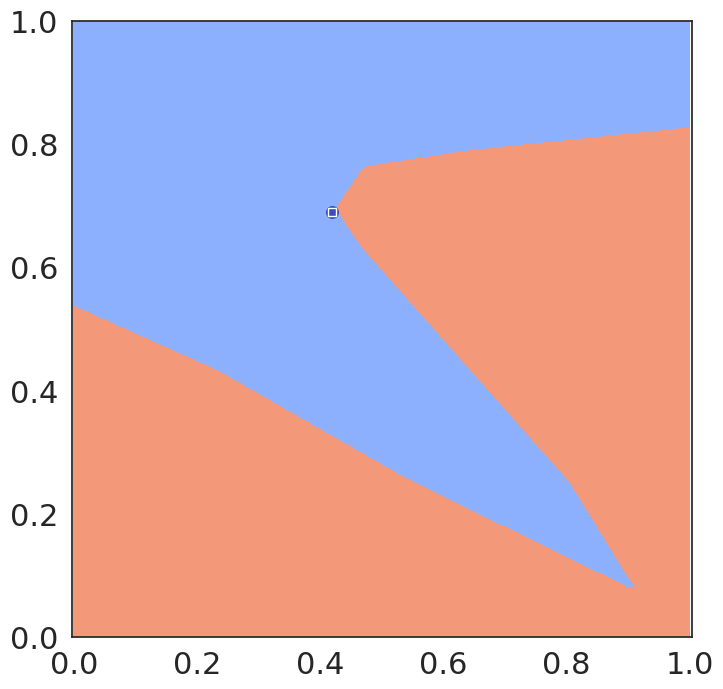

In [9]:
# And we can plot the ball around this to demonstrate...
fig, ax = plt.subplots(figsize=(8, 8))
ax.contourf(XX, YY, -ZZ, cmap="coolwarm", levels=np.linspace(-1000, 1000, 3))
ax.axis("equal")
ax.axis([0, 1, 0, 1])
ax.scatter([test_point[0].item()], [test_point[1].item()],
           c=[0],
           cmap="coolwarm",
           s=70)
ax.add_patch(
    patches.Rectangle((test_point[0].item() - linf_output.best_dist,
                       test_point[1].item() - linf_output.best_dist),
                      linf_output.best_dist * 2,
                      linf_output.best_dist * 2,
                      fill=False))

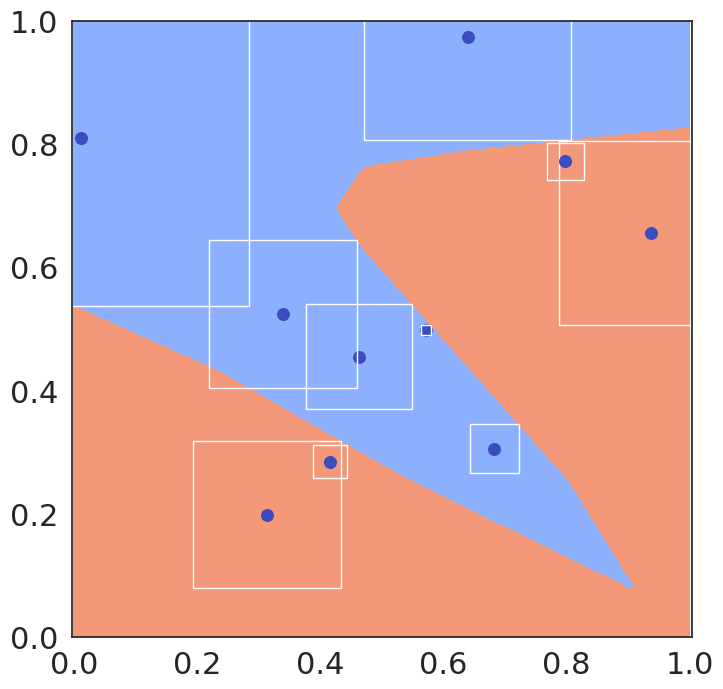

In [10]:
# Now trying with several points to give more pretty pictures
fig, ax = plt.subplots(figsize=(8, 8))
ax.contourf(XX, YY, -ZZ, cmap="coolwarm", levels=np.linspace(-1000, 1000, 3))
ax.axis("equal")
ax.axis([0, 1, 0, 1])
for i in range(10):
    test_point = torch.rand(2)
    linf_output = geo.run(test_point, lp_norm='l_inf', problem_type='min_dist')
    ax.scatter([test_point[0].item()], [test_point[1].item()],
               c=[0],
               cmap="coolwarm",
               s=70)
    ax.add_patch(
        patches.Rectangle((test_point[0].item() - linf_output.best_dist,
                           test_point[1].item() - linf_output.best_dist),
                          linf_output.best_dist * 2,
                          linf_output.best_dist * 2,
                          fill=False))

## Minimum Distance : $\ell_2$
We can do the same things with $\ell_2$ instead of $\ell_\infty$

GeoCert Return Object
	Problem Type: min_dist
	Status: SUCCESS
	Robustness: 0.0084
Original Logits    : [ 0.11238 -0.31346]
Adversarial Logits : [-0.10119 -0.10119]


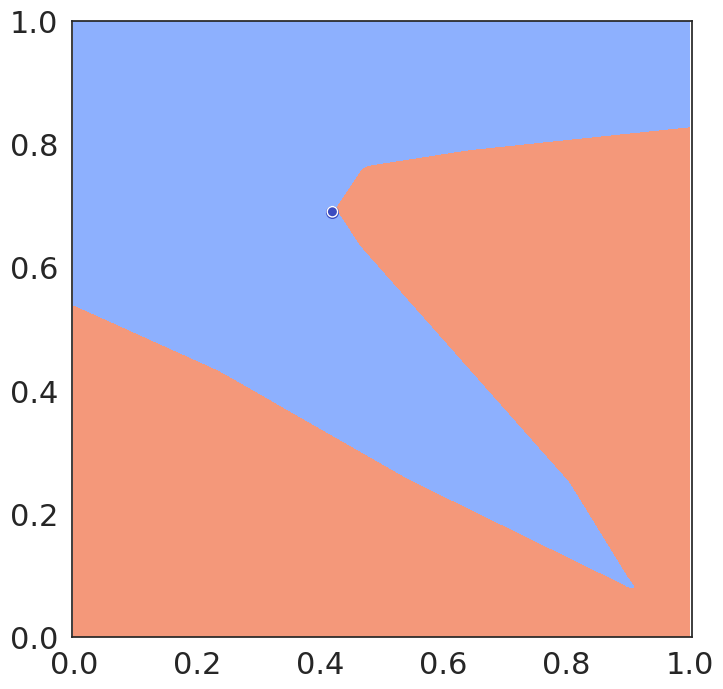

In [11]:
# Single example for computing L_2 min_dists
test_point = torch.Tensor([0.420, 0.69])
l2_output = geo.run(test_point, lp_norm='l_2', problem_type='min_dist')

# Example printout from the return object
print(l2_output)

# Can collect the minimal distance adversarial example and examine its logits
original_logits = net(test_point)
adversarial_logits = net(torch.Tensor(l2_output.best_ex))
print("Original Logits    :", original_logits.detach().numpy())
print("Adversarial Logits :", adversarial_logits.detach().numpy())

# And we can plot the ball around this to demonstrate...
fig, ax = plt.subplots(figsize=(8, 8))
ax.contourf(XX, YY, -ZZ, cmap="coolwarm", levels=np.linspace(-1000, 1000, 3))
ax.axis("equal")
ax.axis([0, 1, 0, 1])
ax.scatter([test_point[0].item()], [test_point[1].item()],
           c=[0],
           cmap="coolwarm",
           s=70)
ax.add_patch(patches.Circle(test_point, l2_output.best_dist, fill=False))

## Decision Problem
Sometimes you might want to ask "Does an adversarial example exist within a ball of specified size?" and just want a yes/no answer. This formulation is useful when considering robustness to a particular threat model and can be faster than the `min_dist` formulation, as if we find an (even suboptimal) adversarial example, we'll return early

In [12]:
# Recall our original test point....
test_point = torch.Tensor([0.420, 0.69])
l2_output = geo.run(test_point, lp_norm='l_2', problem_type='min_dist')
# which has best dist specified by
decision_threshold = l2_output.best_dist

# Now we can try two variants on the decision problem....
safe_region_output = geo.run(test_point,
                             lp_norm='l_2',
                             problem_type='decision_problem',
                             decision_radius=decision_threshold / 2.0)

print("SAFE OUTPUT...")
print(safe_region_output)
# The printout status 'FAILURE' means 'FAILURE' to find an adversarial example within the radius

SAFE OUTPUT...
GeoCert Return Object
	Problem Type: decision_problem
	Status: FAILURE
	Radius 0.00



In [13]:
# On the other hand, if there exists an adversarial example within the radius
# we'll output 'SUCCESS' as the status

unsafe_region_output = geo.run(test_point,
                               lp_norm='l_2',
                               problem_type='decision_problem',
                               decision_radius=decision_threshold * 2.0)

print("UNSAFE OUTPUT...")
print(unsafe_region_output)

UNSAFE OUTPUT...
GeoCert Return Object
	Problem Type: decision_problem
	Status: SUCCESS
	Radius 0.02



## Counting Linear Regions
Finally, we can leverage GeoCert to count the number of linear regions (recall that ReLU nets are piecewise linear, so by 'linear regions', I mean the number of _pieces_) in a specified ball. Note that the domain restrictions are included by default here (so even if the ball extends past the \[0, 1\] hyperbox we've established upon initialization).

In [14]:
geo.verbose = True  # This will take a while, so let's turn on printouts

test_point = torch.Tensor([0.420, 0.69])
region_count = geo.run(test_point,
                       lp_norm='l_inf',
                       problem_type='count_regions',
                       decision_radius=0.4)

---Initial Polytope---
(p0) Popped: 0.004109  | 0.400000
(p0) Popped: 0.051443  | 0.400000
(p0) Popped: 0.064047  | 0.400000
(p0) Popped: 0.083156  | 0.400000
(p0) Popped: 0.083729  | 0.400000
(p0) Popped: 0.089809  | 0.400000
(p0) Popped: 0.090883  | 0.400000
(p0) Popped: 0.092288  | 0.400000
(p0) Popped: 0.092576  | 0.400000
(p0) Popped: 0.100404  | 0.400000
(p0) Popped: 0.100888  | 0.400000
(p0) Popped: 0.101229  | 0.400000
(p0) Popped: 0.101659  | 0.400000
(p0) Popped: 0.103719  | 0.400000
(p0) Popped: 0.105680  | 0.400000
(p0) Popped: 0.107344  | 0.400000
(p0) Popped: 0.108332  | 0.400000
(p0) Popped: 0.111641  | 0.400000
(p0) Popped: 0.112828  | 0.400000
(p0) Popped: 0.113986  | 0.400000
(p0) Popped: 0.114437  | 0.400000
(p0) Popped: 0.116043  | 0.400000
(p0) Popped: 0.116043  | 0.400000
(p0) Popped: 0.098174  | 0.400000
(p0) Popped: 0.103399  | 0.400000
(p0) Popped: 0.114724  | 0.400000
(p0) Popped: 0.114724  | 0.400000
(p0) Popped: 0.113504  | 0.400000
(p0) Popped: 0.124016  | 

In [15]:
print(region_count)

GeoCert Return Object
	Problem Type: count_regions
	Status: SUCCESS
	Radius 0.40
	Num Linear Regions: 105
